<a href="https://colab.research.google.com/github/emiliauskas-fuzzy/scalaua.github.com/blob/master/Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 <h1><center>Report on reviews dynamic</center></h1>
 
<br> </br>
#### Please, going thru this notebook be sure, that you have ran all the cells in "Imports", "Uploading data" and  "Settings" parts.
<br> </br>
#### This notebook  contains only highlights of work. And made mostly for demonstration. If you are interested in details of data extraction or other analysis made - look other notebooks and/or contact me.
<br> </br>
#### If you want to know more about process or keywords generation or update data, to have fresh analysis go thru (also, if you want to update word groups look at next notebook, as well):
#### [this_notebook](https://datalabs.stacktome.com/notebooks/notebooks/recs/reviews_dynamic/key_words_generation_eval.ipynb)
<br> </br>
#### If you are interested in process of groups generation look:
#### [this one](https://datalabs.stacktome.com/notebooks/notebooks/recs/reviews_dynamic/generating_word_groups.ipynb)
<br> </br>
#### For more details on dynamic evaluation look:
#### [this notebook](https://datalabs.stacktome.com/notebooks/notebooks/recs/reviews_dynamic/dynamik_marks.ipynb)
<br> </br>
#### Some clustering and common features may be found:
#### [here](https://datalabs.stacktome.com/notebooks/notebooks/recs/reviews_dynamic/Clustering%20experiments%2C%20common%20static.ipynb)
#### [and here](https://datalabs.stacktome.com/notebooks/notebooks/recs/reviews_dynamic/First_experiments.ipynb)
<br> </br>
#### If you are interested in details of utilities functions:
#### It may be found in [Utils](https://datalabs.stacktome.com/edit/notebooks/recs/reviews_dynamic/utils.py)
<br> </br>
### Content of this notebook:
* [Imports](#Imports)
* [Uploading data](#Data)
* [Settings, you want to use](#Settings)
* [Some common static statistics](#Static)
    * [Wordcloud](#Wcloud)
    * [Words frequency](#W_freq)
    * [Frequent n-grams](#N-grams)
* [Common reviews dynamic](#Common_dynamic)
* [Meaning groups analysis](#Meaning_groups)
* [Conclusion](#Conclusion)



### Imports: <a class="anchor" id="Imports"></a>

(Run cells below please)

In [ ]:
#imports needed
from getpass import getpass
import os

os.environ['USER'] = input('Enter the username of your Github account: ')
os.environ['PASSWORD'] = getpass('Enter the password of your Github account: ')
os.environ['GITHUB_AUTH'] = os.environ['USER'] + ':' + os.environ['PASSWORD']

!rm -rf report # To remove the previous clone of the Github repository
!git clone https://$GITHUB_AUTH@github.com/stacktome/report.git

os.environ['USER'] = os.environ['PASSWORD'] = os.environ['GITHUB_AUTH'] = ""

!ls
%cd ./report/reviews_dynamic/
#data procesing
import pandas as pd
import numpy as np
import ast

#viz
import matplotlib.pyplot as plt
from IPython.core.display import display,HTML
from ipywidgets import *
import warnings
warnings.filterwarnings('ignore')

#nlp
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
nltk.download('book', quiet=True)

#custom utils
from utils import get_reviews_by_group
from utils import plot_wordcloud
from utils import freq_words
from utils import plot_with_sub
from utils import get_counts_ts
from utils import plot_trend
from utils import fr_fill_mean

print('imports done')

Enter the username of your Github account: emiliauskas-fuzzy
Enter the password of your Github account: ··········
Cloning into 'report'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 29 (delta 7), reused 29 (delta 7), pack-reused 0
Unpacking objects: 100% (29/29), done.
Checking out files: 100% (20/20), done.
report	sample_data
/content/report/reviews_dynamic
imports done


### Upload data we need:<a class="anchor" id="Data"></a>

In [ ]:
print("Uploading word groups...")
prods_words_df = pd.read_csv("trans_data/prods_words_grouped_lem.csv")
orders_words_df = pd.read_csv("trans_data/orders_words_grouped_lem.csv")

print("Uploading products reviews...")
# product_reviews= pd.read_csv("trans_data/product_reviews.csv")
product_reviews_good = pd.read_csv("trans_data/product_reviews_good.csv")
product_reviews_bad = pd.read_csv("trans_data/product_reviews_bad.csv")
product_reviews = pd.concat([product_reviews_good, product_reviews_bad])

# print("Uploading order reviews...")
# order_reviews= pd.read_csv("trans_data/order_reviews.csv")
order_reviews_good = pd.read_csv("trans_data/order_reviews_good.csv")
order_reviews_bad = pd.read_csv("trans_data/order_reviews_bad.csv")
order_reviews = pd.concat([order_reviews_good, order_reviews_bad])

print("Transform data to format needed...")
product_reviews_bad.product_review_tokens = product_reviews_bad.product_review_tokens.apply(ast.literal_eval)
product_reviews_good.product_review_tokens = product_reviews_good.product_review_tokens.apply(ast.literal_eval)
product_reviews_bad.lematized = product_reviews_bad.lematized.apply(ast.literal_eval)
product_reviews_good.lematized = product_reviews_good.lematized.apply(ast.literal_eval)

order_reviews_bad.order_review_tokens = order_reviews_bad.order_review_tokens.apply(ast.literal_eval)
order_reviews_good.order_review_tokens = order_reviews_good.order_review_tokens.apply(ast.literal_eval)
order_reviews_bad.lematized = order_reviews_bad.lematized.apply(ast.literal_eval)
order_reviews_good.lematized = order_reviews_good.lematized.apply(ast.literal_eval)

order_reviews_bad.dropna(subset = ["order_review_text"], inplace = True)
order_reviews_good.dropna(subset = ["order_review_text"], inplace = True)
order_reviews.dropna(subset = ["order_review_text"], inplace = True)

product_reviews_bad.dropna(subset = ["product_review_text"], inplace = True)
product_reviews_good.dropna(subset = ["product_review_text"], inplace = True)
product_reviews.dropna(subset = ["product_review_text"], inplace = True)

prods_words_df.dropna(inplace=True)
orders_words_df.dropna(inplace=True)

print("data uploaded")

Uploading word groups...
Uploading products reviews...
Transform data to format needed...
data uploaded


### Set up details of analysis you want to get: <a class="anchor" id="Settings"></a>

In [ ]:
use_lemmitized_tokens = True#recommended value is True, since it tends to more consolidated groups
review_type_to_analyze = "products" 

In [ ]:
assert review_type_to_analyze == "products" or review_type_to_analyze == "orders", "You've specified incorrect 'review_type_to_analyze' value"   
assert use_lemmitized_tokens == True or use_lemmitized_tokens == False, "You've specified incorrect 'use_lemmitized_tokens' value"

if review_type_to_analyze == "products":
    reviews = product_reviews
    reviews_bad = product_reviews_bad
    reviews_good = product_reviews_good
    tokens_col = "product_review_tokens"
    text_column = "product_review_text"
    words_df = prods_words_df
    
if review_type_to_analyze == "orders":
    reviews = order_reviews
    reviews_bad = order_reviews_bad
    reviews_good = order_reviews_good
    tokens_col = "order_review_tokens"
    text_column = "order_review_text"
    words_df = orders_words_df

### Some common static statistics:<a class="anchor" id="Static"></a>

#### Wordcloud:<a class="anchor" id="Wcloud"></a>

HTML(value="<font size='4'> Wordcloud for <b>good</b> reviews: </font>")

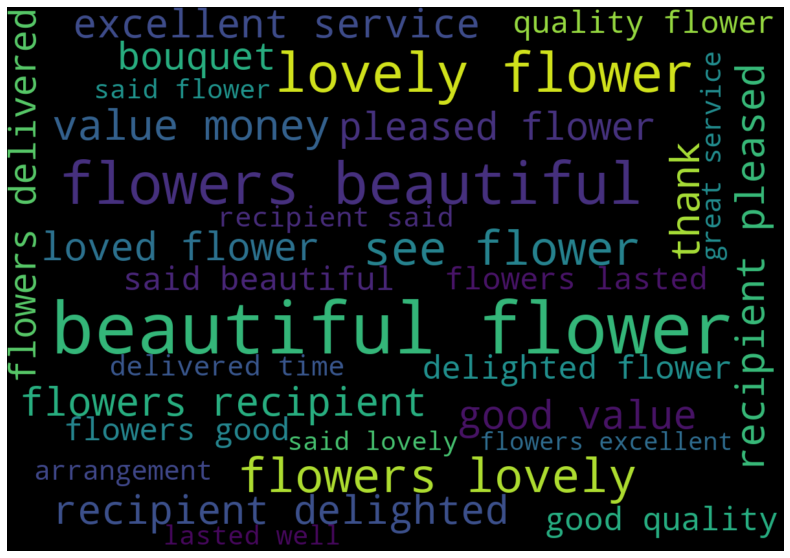

HTML(value="<font size='4'>Wordcloud for <b>bad</b> reviews:</font>")

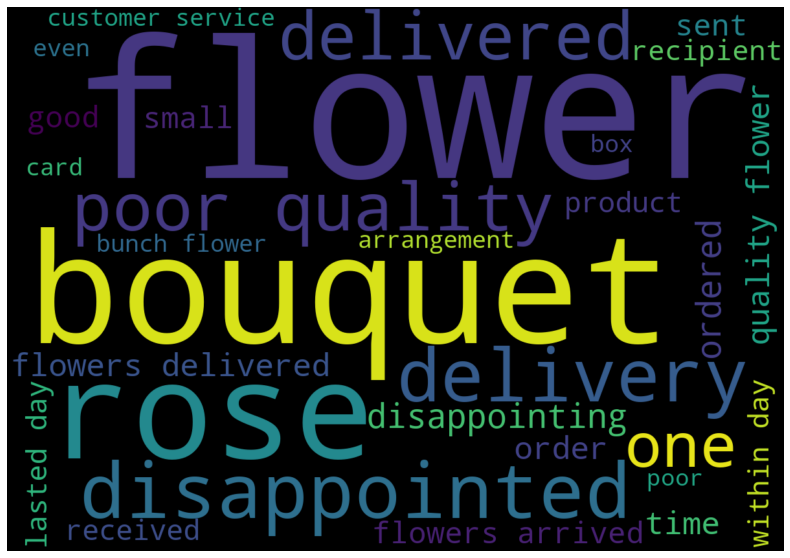

In [ ]:
display(HTML("<font size='4'> Wordcloud for <b>good</b> reviews: </font>"))
plot_wordcloud(reviews_good, tokens_col, " ")
plt.show()

display(HTML("<font size='4'>Wordcloud for <b>bad</b> reviews:</font>"))
plot_wordcloud(reviews_bad, tokens_col, " ")
plt.show()

#### Words frequency distribution: <a class="anchor" id="W_freq"></a>

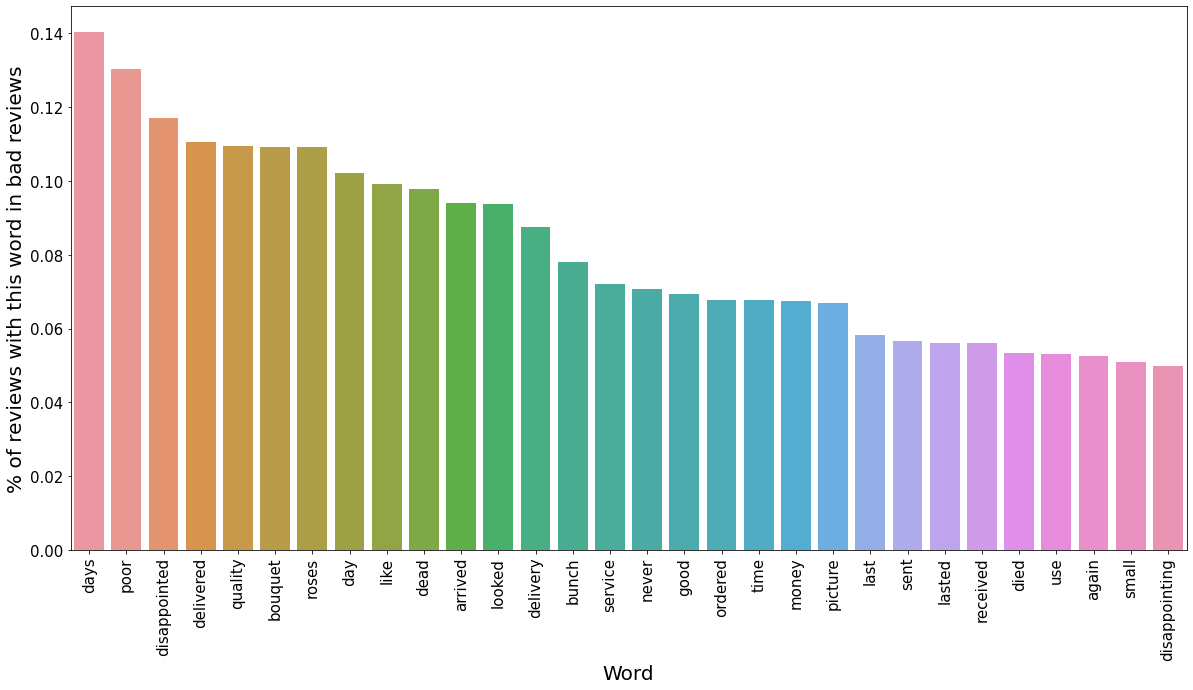

In [ ]:
freq_words(reviews_bad[tokens_col].values, type_of = "bad")

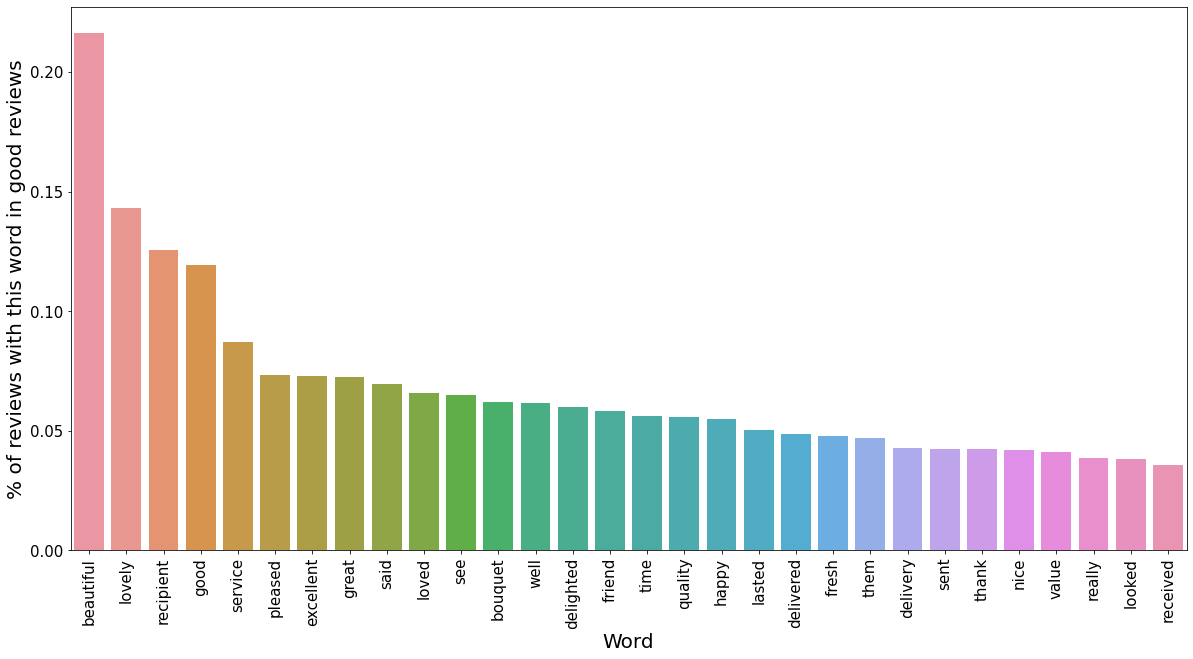

In [ ]:
freq_words(reviews_good[tokens_col].values, type_of = "good")

#### Now let's look on most frequent n-grams: <a class="anchor" id="N-grams"></a>

In [ ]:
def get_top_n_grams(n, reviews, text_column, vectorizer, reviews_type): 
    reviews_text = reviews[text_column]
    vectorizer.fit(reviews_text)
    tfidf_matrix = vectorizer.transform(reviews_text)
    feature_array = np.array(vectorizer.get_feature_names())
    tfidf_sorting = np.argsort(tfidf_matrix.toarray()).flatten()[::-1]
    
    top_n = feature_array[tfidf_sorting][:n]
    top_n_df = pd.DataFrame(top_n, columns = ["n_gram"])
    display(HTML("<font size='4'>Most common n-grams in <b>bad</b> reviews:</font>".format(reviews_type)))
    display(top_n_df)
    
vectorizer = TfidfVectorizer(max_features=100, 
                             ngram_range=(2, 3),
                             stop_words = stopwords.words('english'),
                             use_idf = False)

# top n-grams for bad reviews
get_top_n_grams(n=10,
               reviews = reviews_bad,
               text_column = text_column,
               vectorizer = vectorizer,
               reviews_type = "bad")

# top n-grams for good reviews
get_top_n_grams(n=10,
               reviews = reviews_good,
               text_column = text_column,
               vectorizer = vectorizer,
               reviews_type = "good")

HTML(value="<font size='4'>Most common n-grams in <b>bad</b> reviews:</font>")

,n_gram
0,would use
1,flowers never
2,flowers died within
3,flowers fresh
4,flowers good
5,flowers half
6,flowers last
7,flowers lasted
8,flowers lasted days
9,flowers look


HTML(value="<font size='4'>Most common n-grams in <b>bad</b> reviews:</font>")

,n_gram
0,quality flowers
1,excellent quality
2,well received
3,flowers told
4,flowers looked
5,flowers lovely
6,flowers nice
7,flowers recipient
8,flowers said
9,flowers sent


### Common reviews dynamic: <a class="anchor" id="Common_dynamic"></a>

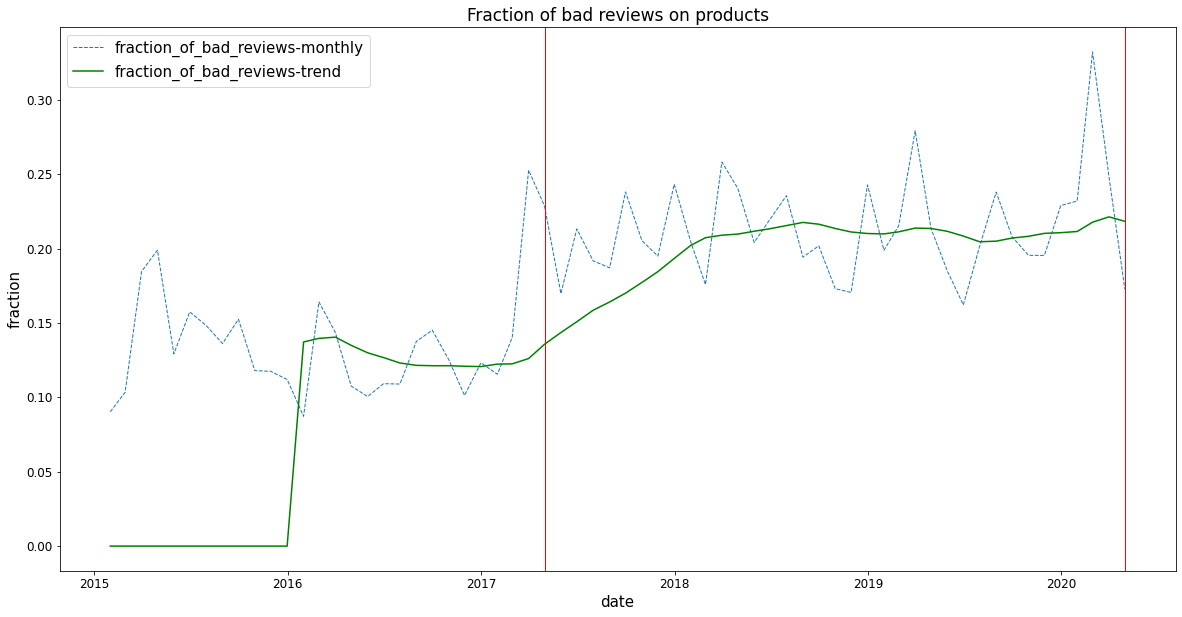

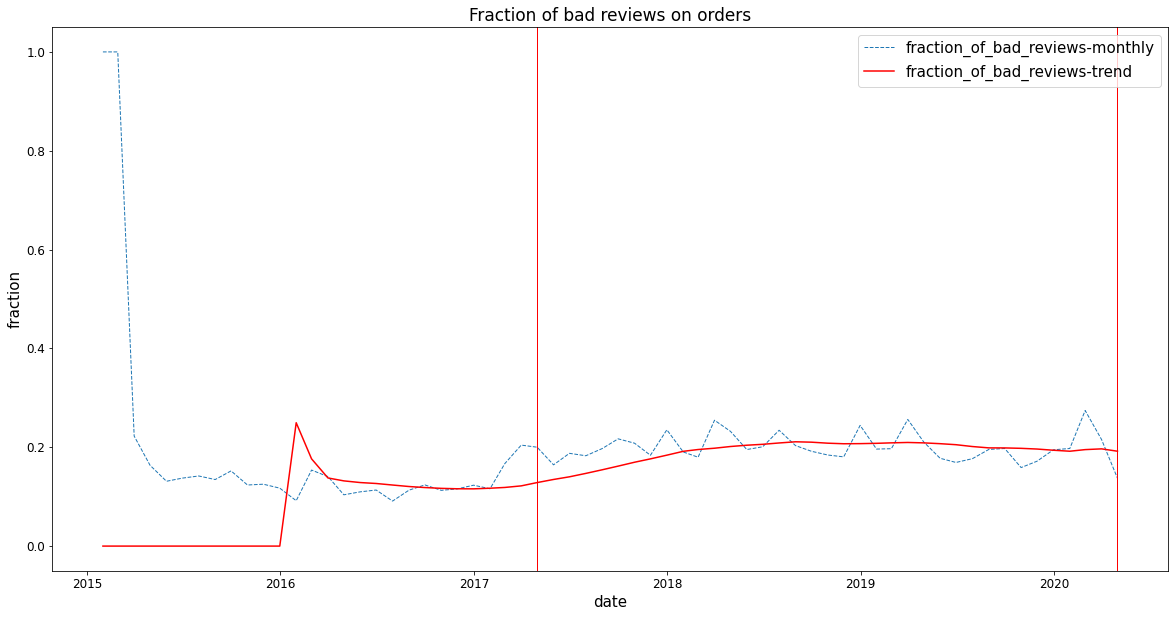

In [ ]:
product_reviews_bad_ts = get_counts_ts(product_reviews_bad, freq = "M")
product_reviews_ts = get_counts_ts(product_reviews, freq = "M")
plt.figure(figsize = (20,10))
plot_trend(fr_fill_mean(product_reviews_bad_ts,product_reviews_ts), '01.01.2015', '29.05.2020', color = "g", title = "Fraction of bad reviews on products", label = "fraction_of_bad_reviews")

order_reviews_bad_ts = get_counts_ts(order_reviews_bad, freq = "M")
order_reviews_ts = get_counts_ts(order_reviews, freq = "M")
plt.figure(figsize = (20,10))
plot_trend(fr_fill_mean(order_reviews_bad_ts,order_reviews_ts), '01.01.2015', '29.05.2020', color = "r", title = "Fraction of bad reviews on orders", label = "fraction_of_bad_reviews")

### And, finally meaning groups analysis: <a class="anchor" id="Meaning_groups"></a>
<br></br>
#### Few words on how to use it:
Script under hood - plots two timeserieses (and their trends).
<br>First one is fraction of <b>bad reviews, which belongs to group</b> (may be interpreted as topic) among all <b>bad reviews</b> (<b>fraction_of_bad</b> below).</br>
<br>Second one - is fraction of <b>bad reviews, which belongs to group</b>(may be interpreted as topic) among <b>all reviews</b> (<b>fraction_of_all</b> below).</br>
<br></br>
<br>Notice, that groups(topics) - is just tegs, so each review may be associated with several groups(topics).</br>
<br></br>
<br>Whenever <b>fraction_of_all growth</b> - it means that there are more reviews related to topic you are analyzing. It may, mean two things: first is that you have some problems related to this topic; second is that this topic related to some other topic, for example - customers, who have bought flowers of bad quality will say that they were overpraced, and review will be taged as "price related" as well. </br>
<br></br>
<br> <b>fraction_of_bad growth</b> - allows you to understand categories balance changes within bad reviews </br>
<br></br>
<br> Groups analysis - may not show you full picture, since it's not to consolidate( for example: within flowers_condition_or_lifetime group you may have growth in flowers packaging quality, and problems related to their longevity, summing it - you'll haven't see significant increace), so pleace - use <b>"Plot subgroups"</b> </br>
<br></br>
<br> When you are analyzing "products" you may assume, that growth of fraction of bad reviews statistically significant whenever it's bigger then 0.1% for  "orders" significance treshold 0.06% - 0.07%.</br>
<br></br>
<br> There are 4 groups - growth in which - highly tends to be side effect of growth in other groups: "price", "holiday", "recepient" and "alternative", so this groups interested mostly in prospect of their subgroups analysis.</br>
<br></br>
<br><b>Look on curves,</b> since just numbers of absolute growth aren't to infomative</br>
<br></br>
<br>To change period for which difference counted - set <b>time_frame</b> to be equal to number of last months you want.</br>

In [ ]:
all_bad_reviews_ts = get_counts_ts(reviews_bad, freq = "M")
all_reviews_ts = get_counts_ts(reviews, freq = "M")

display(HTML("<font size='5'>Use 'ctrl+click' to select multiple groups simultiniously</font>"))

def visualise_dfs():
    options= words_df.word_group.unique()
    options= options[options != 'no_group']
    
    groups = SelectMultiple(
        options= options,
        value=["delivery"],
        rows=10,
        description='groups:')
     
    plt = widgets.Checkbox(
        value=False,
        description='plot important words in group',
        disabled=False)
    
    show = widgets.Checkbox(
        value=False,
        description='Plot subgroups',
        disabled=False)
    
    time_frame = IntSlider(
      value=36,
      min=0,
      max=60,
      step=1,
      description='time_frame:',
      disabled=False,
      continuous_update=False,
      orientation='horizontal',
      readout=True,
      readout_format='d')
    
    n_sub = IntSlider(
      value=3,
      min=0,
      max=20,
      step=1,
      description='n_words:',
      disabled=False,
      continuous_update=False,
      orientation='horizontal',
      readout=True,
      readout_format='d')
    
    interact(lambda groups, show, plot_words, n_sub, count_for_last_m: 
             plot_with_sub(groups, n_sub, reviews_bad, words_df, 
                           all_bad_reviews_ts, all_reviews_ts, show_subgroups = show, plot_important_words = plot_words,
                           count_for_last_m = count_for_last_m),  
             groups=groups, show = show, n_sub = n_sub, plot_words = plt, count_for_last_m = time_frame )
visualise_dfs()

HTML(value="<font size='5'>Use 'ctrl+click' to select multiple groups simultiniously</font>")

interactive(children=(SelectMultiple(description='groups:', index=(0,), options=('delivery', 'services_not_rel…

<h1><center>Conclusion</center></h1> <a class="anchor" id="Conclusion"></a>
<h4><center> Analysis made for March 4 2019</center></h4>
<br></br>
<h2><center> From products reviews</center></h2>
<br></br>
<h3>Delivery</h3>(up to 1.55% of absolute growth)
<br></br>
<font color='grey'><br><b>Significant things, that have shown growth:</b></br></font>
<br>delivery</br>
<br>courier actions</br>
<br></br>
<font color='grey'><br><b>Significant things, that haven't shown growth:</b></br></font>
<br></br>
<br></br>

<h3>Services not related to delivery</h3>(up to 0.52% of absolute growth)
<br></br>
<font color='grey'><br><b>Significant things, that have shown growth:</b></br></font>
<br>responce via mail</br>
<br>refund policy</br>
<br></br>
<font color='grey'><br><b>Significant things, that haven't shown growth:</b></br></font>
<br>phone existing</br>
<br>interaction with website</br>
<br>advertising policy</br>
<br></br>
<br></br>

<h3>Flowers condition or lifetime</h3>(up to 1.25% of absolute growth)
<br></br>
<font color='grey'><br><b>Significant things, that have shown growth:</b></br></font>
<br>subjective_look ("poor" has huge influance here)</br>
<br>size</br>
<br>freshness</br>
<br>mech_damage</br>
<br>longevity(actually quite similar to freshness, but, not the same as I think)</br>
<br></br>
<font color='grey'><br><b>Significant things, that haven't shown growth:</b></br></font>
<br>addons</br>
<br>package</br>
<br>fragrance</br>
<br>expectations about ordered size (whenever customer ordered grandissimo(or else) and was dissapointed)</br>


<h2><center> From orders reviews</center></h2>
<br></br>
<h3>Delivery</h3>(up to 3.94% of absolute growth(36 month), 6.16%(24 month))
<br></br>
<font color='grey'><br><b>Significant things, that have shown growth:</b></br></font>
<br>delivery</br>
<br>courier actions</br>
<br></br>
<font color='grey'><br><b>Significant things, that haven't shown growth:</b></br></font>
<br></br>
<br></br>

<h3>Services not related to delivery</h3>(up to 1.98% of absolute growth(36 month), 2.91%(24 month))
<br></br>
<font color='grey'><br><b>Significant things, that have shown growth:</b></br></font>
<br>responce via mail</br>
<br>refund policy</br>
<br>interaction with website</br>
<br></br>
<font color='grey'><br><b>Significant things, that haven't shown growth:</b></br></font>
<br>phone existing</br>
<br>advertising policy</br>
<br></br>
<br></br>

<h3>Flowers condition or lifetime</h3>(up to  2.52% of absolute growth(36 month), 2.80%(24 month))
<br></br>
<font color='grey'><br><b>Significant things, that have shown growth:</b></br></font>
<br>freshness</br>
<br>subjective_look ("poor" has huge influance here)</br>
<br>longevity(actually quite similar to freshness, but, not the same as I think)</br>
<br>size</br>
<br>mech_damage</br>
<br></br>
<br></br>
<font color='grey'><br><b>Significant things, that haven't shown growth:</b></br></font>
<br>addons</br>
<br>package</br>
<br>fragrance</br>
<br>expectations about ordered size (whenever customer ordered grandissimo(or else) and was dissapointed)</br>
<br></br>
<br></br>
<h2><center> Comparing and general thoughts</center></h2>
<br>Most problems associated with delivery, as expected.</br> 
<br>The fraction of bad reviews related to delivery, always was pretty high, but during last 36 monthes- it've shown significant growth.</br>
<br>At the same time, while absolute growth of fraction of delivery related problems is biggest, the related one - biggest for flowers condition and lifetime (especially for freshness and longevity).</br>
<br>Also there are some problems with refund policie and email responses. There were significant improvements of this during (end of 2015 - mid of 2017), but after that - there are some problems.(should be checked)</br>
<br></br>
<br></br>
<h2><center>Future work</center></h2>
<font color='grey'><br><b>This task related:</b></br></font>
<br>Use customer history related to reviews, to understand customer loyality, and estimate money loss.</br> 
<br>Use particular products related to reviews, to see how problems related to actual product.</br> 
<br>Use splitting reviews, with tag "delivery" on "dpd" and "yodel", to see what's more problematic ("yodel", mentioned more frequent).</br> 
<br>Build map of bad reviews related to delivery to understand how it related to county.</br> 
<br>For most important words - check the context, to ensure, that it's understood correctly.</br>
<br>To ensure on conclusions - more advanced teckniks may be used for topic extraction</br>
<br></br>

<font color='grey'><br><b>Other directions related:</b></br></font>
<br>Topic extractions from this task(with some improvements) may be used for premitive "reviews auto-replying system"</br>
<br>Also it may be used as "long term user satisfaction monitoring", and with some changes, used as part of "short term user satisfaction monitoring"</br>

<br></br>
<h3>Note: "significant things, that have shown growth" - not the same as subgroups. It's very similar, but still - in rare cases it may merge or split some subgroups, based on individual word analysis.</h3>
<h3>Note: "significant things, that have shown growth" ordered by significance.</h3>